<a href="https://colab.research.google.com/github/Axel0087/NLP2023/blob/main/week39%20lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load af Dataset og grundfunktioner

In [1]:
%%capture
!pip install datasets
!pip install bpemb

In [2]:
from torch.utils.data import DataLoader, Dataset
import nltk
from bpemb import BPEmb
import string
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from torch import nn
import torch

In [3]:
dataset = load_dataset("copenlu/answerable_tydiqa")
nltk.download('punkt')

train_set = dataset["train"]
validation_set = dataset["validation"]

def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def get_language(dataset, lang):
  return dataset.filter(lambda x: x["language"] == lang)#[row for row in dataset if row['language'] == lang]

def get_answerble(dataset):
  return dataset.filter(lambda x: x["annotations"]["answer_start"] != [-1])


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/116067 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13325 [00:00<?, ? examples/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
vocab_size = 25000
encoding_dim = 100

bpemb_ar = BPEmb(lang='ar', dim=encoding_dim, vs=vocab_size)
bpemb_bn = BPEmb(lang='bn', dim=encoding_dim, vs=vocab_size)
bpemb_in = BPEmb(lang='id', dim=encoding_dim, vs=vocab_size)
bpemb_en = BPEmb(lang='en', dim=encoding_dim, vs=vocab_size)

downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.model


100%|██████████| 742254/742254 [00:00<00:00, 916601.53B/s]


downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9491724/9491724 [00:01<00:00, 5439132.55B/s] 


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.model


100%|██████████| 863227/863227 [00:00<00:00, 1100780.13B/s]


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9517491/9517491 [00:01<00:00, 5893028.39B/s]


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.model


100%|██████████| 650018/650018 [00:00<00:00, 833569.45B/s]


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9465922/9465922 [00:01<00:00, 5817662.88B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.model


100%|██████████| 661443/661443 [00:00<00:00, 828395.69B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9477142/9477142 [00:01<00:00, 5812706.70B/s] 


### English

In [5]:
train_english = get_language(train_set, "english")
val_english = get_language(validation_set, "english")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [6]:
train_english_answerble = get_answerble(train_english)
val_english_answerble = get_answerble(val_english)

Filter:   0%|          | 0/7389 [00:00<?, ? examples/s]

Filter:   0%|          | 0/990 [00:00<?, ? examples/s]

In [7]:
train_english_tt = train_english_answerble.train_test_split(test_size=0.2)

### language data

In [8]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [9]:
train_arabic_answerble = get_answerble(train_arabic)
val_arabic_answerble = get_answerble(val_arabic)

train_bengali_answerble = get_answerble(train_bengali)
val_bengali_answerble = get_answerble(val_bengali)

train_indonesian_answerble = get_answerble(train_indonesian)
val_indonesian_answerble = get_answerble(val_indonesian)

Filter:   0%|          | 0/29598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1902 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4779 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11394 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1191 [00:00<?, ? examples/s]

In [10]:
train_arabic_tt = train_arabic_answerble.train_test_split(test_size=0.2)
train_bengali_tt = train_bengali_answerble.train_test_split(test_size=0.2)
train_indonesian_tt = train_indonesian_answerble.train_test_split(test_size=0.2)

# Padding & datasetreader

In [11]:
def text_to_ids(text, tokenizer):
    input_ids = tokenizer.encode_ids(text)
    return input_ids, len(input_ids)

def pad_input(input):
    input_ids = [i[0] for i in input]
    seq_lens = [i[1] for i in input]
    answer_span_label = [i[2] for i in input]

    max_length = max(seq_lens)
    input_ids = [(i + [0] * (max_length - len(i))) for i in input_ids]
    label_ids = [(i + [0] * (max_length - len(i))) for i in answer_span_label]

    assert all(len(i) == max_length for i in input_ids)

    return (torch.tensor(input_ids),
        torch.tensor(seq_lens),
        torch.tensor(label_ids))


In [12]:
class DatasetReader(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        question = get_question(row)
        document = get_document(row)
        answer = get_answer(row)



        combined_question_document = question + ' <SEP> ' + document
        # Locate answer in document

        #print(combined_question_document.replace(" ", "").find(answer))
        answer_start_char = combined_question_document.replace(" ", "").find(answer.replace(" ", ""))
        #answer_start_char = combined_question_document.find(answer)
        if answer_start_char == -1:  # Answer not found in document
            raise ValueError("Answer not found in document.")

        input_ids, token_char_positions,tokens = self.text_to_ids_with_char_positions(combined_question_document)
       # print('token_char_positions',token_char_positions)
        seq_lens = len(input_ids)

        # Convert character indices to token indices
        answer_start_token, answer_end_token = self.char_to_token_indices(answer_start_char, answer, token_char_positions)
        #print('answer_start_token, answer_end_token',answer_start_token, answer_end_token)
       # print(tokens[answer_start_token],tokens[answer_end_token])
        label_sequence2 = [0] * len(input_ids)
        for i in range(len(label_sequence2)):
          label_sequence2[i]=i

      #  print(label_sequence2)
        label_sequence = [0] * len(input_ids)
        if answer_start_token != -1 and answer_end_token != -1:
            label_sequence[answer_end_token] = 2    # Mark end of answer
            for i in range(answer_start_token,answer_end_token ):
              label_sequence[i] = 2
            for i in range(answer_end_token, answer_start_token):
              label_sequence[i] = 2

            label_sequence[answer_start_token] = 1  # Mark start of answer

        return input_ids, seq_lens, label_sequence

    def text_to_ids_with_char_positions(self, text):
        """
        Tokenize the text and return token ids along with character start positions for each token.
        """
        input_ids, seq_lens = text_to_ids(text, self.tokenizer)

        tokens = self.tokenizer.encode(text)
       # input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      #  print(tokens)
        token_char_positions = []
        char_position = 0
        for token in tokens:
            token_char_positions.append(char_position)
            char_position += len(token.replace("▁", ""))  # Adjust for BPE '##' prefix on subwords

        return input_ids, token_char_positions,tokens

    def char_to_token_indices(self, start_char, answer, token_char_positions):
        """
        Convert character-level indices of the answer to token-level indices.
        """
        end_char = start_char + len( answer.replace(" ", "")) - 1
     #   print('start_char',start_char)
      #  print('end_char',end_char)
       # start_token = next((i for i, pos in enumerate(token_char_positions) if pos >= start_char), -1)

        if start_char >= token_char_positions[-1]:
           start_token = len(token_char_positions) - 1
        else:
           start_token = next((i for i, pos in enumerate(token_char_positions) if pos >= start_char), -1)



        if end_char >= token_char_positions[-1]:
           end_token = len(token_char_positions) - 1
        else:
           end_token = next((i for i, pos in enumerate(token_char_positions) if pos > end_char), -1) - 1

        return start_token, end_token

In [ ]:
text = 'Coordinates: \nالقطائع هي المدينة التي بناها أحمد بن طولون في مصر لتكون عاصمته، بدأ في تاسيسها في شعبان سنة (256هـ) وظلت عاصمة مصر طول العصر الطولونى.'
print(len(text))
position = text.find('القطائع')
print(position)  #

149
14


In [ ]:
print(len(text))
print(len(text)-position)

149
135


In [ ]:
ar_test = train_arabic.filter(lambda x: 'القطائع' in x["annotations"]["answer_text"])


Filter:   0%|          | 0/29598 [00:00<?, ? examples/s]

In [ ]:
ar_test

Dataset({
    features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
    num_rows: 1
})

In [ ]:
ar_test[0]

{'question_text': 'ما هي المدينة التي بناها أحمد بن طولون في مصر لتكون عاصمته؟',
 'document_title': 'القطائع',
 'language': 'arabic',
 'annotations': {'answer_start': [14], 'answer_text': ['القطائع']},
 'document_plaintext': 'Coordinates: \nالقطائع هي المدينة التي بناها أحمد بن طولون في مصر لتكون عاصمته، بدأ في تاسيسها في شعبان سنة (256هـ) وظلت عاصمة مصر طول العصر الطولونى.',
 'document_url': 'https://ar.wikipedia.org/wiki/%D8%A7%D9%84%D9%82%D8%B7%D8%A7%D8%A6%D8%B9'}

In [ ]:
print(bpemb_ar.encode('القطائع'))
bpemb_ar.encode_ids('القطائع')

['▁القط', 'ائع']


[2621, 2573]

In [ ]:
print(bpemb_ar.encode('Coordinates: \nالقطائع هي المدينة التي بناها أحمد بن طولون في مصر لتكون عاصمته، بدأ في تاسيسها في شعبان سنة (256هـ) وظلت عاصمة مصر طول العصر الطولونى.'))
bpemb_ar.encode_ids('Coordinates: \nالقطائع هي المدينة التي بناها أحمد بن طولون في مصر لتكون عاصمته، بدأ في تاسيسها في شعبان سنة (256هـ) وظلت عاصمة مصر طول العصر الطولونى.')


['▁co', 'ord', 'in', 'ates', ':', '▁', '\n', 'ال', 'قط', 'ائع', '▁هي', '▁المدينة', '▁التي', '▁بناها', '▁أحمد', '▁بن', '▁طول', 'ون', '▁في', '▁مصر', '▁لتكون', '▁عاصم', 'ته', '،', '▁بدأ', '▁في', '▁ت', 'اسيس', 'ها', '▁في', '▁شعبان', '▁سنة', '▁(000', 'ه', 'ـ)', '▁وظلت', '▁عاصمة', '▁مصر', '▁طول', '▁العصر', '▁الطول', 'ون', 'ى', '.']


[7070,
 3312,
 255,
 10734,
 24907,
 24875,
 0,
 3,
 495,
 2573,
 193,
 676,
 132,
 22231,
 1013,
 139,
 1474,
 31,
 14,
 822,
 6209,
 13799,
 166,
 24901,
 700,
 14,
 9,
 11550,
 30,
 14,
 10935,
 254,
 2107,
 24892,
 7417,
 15180,
 3329,
 822,
 1474,
 2214,
 8419,
 31,
 24903,
 24898]

In [ ]:
train_bengali_tt['train'][1]

{'question_text': 'রাশিয়ার সরকারি ভাষা কী ?',
 'document_title': 'রুশ ভাষা',
 'language': 'bengali',
 'annotations': {'answer_start': [0], 'answer_text': ['রুশ ভাষা']},
 'document_plaintext': 'রুশ ভাষা রাশিয়ার একমাত্র সরকারি ভাষা। এছাড়াও এটি বেলারুশ, কাজাকিস্তান, কিরগিজস্তান, ইউক্রেনের স্বায়ত্বশাসিত ক্রিমেয়া এবং মলদোভার ত্রান্সনিস্ত্রিয়ার অন্যতম সরকারি ভাষা। রুশ ভাষা জাতিসংঘের ছয়টি দাপ্তরিক ভাষার একটি।',
 'document_url': 'https://bn.wikipedia.org/wiki/%E0%A6%B0%E0%A7%81%E0%A6%B6%20%E0%A6%AD%E0%A6%BE%E0%A6%B7%E0%A6%BE'}

In [ ]:
D_reader = DatasetReader(train_bengali_tt['train'],bpemb_bn)

In [ ]:
D_reader[1]

token_char_positions [0, 8, 16, 21, 22, 24, 28, 32, 34, 42, 46, 48, 49, 50, 52, 53, 54, 60, 64, 67, 70, 78, 86, 91, 92, 94, 97, 100, 105, 113, 125, 130, 134, 142, 147, 148, 149, 150, 151, 155, 158, 164, 172, 179, 180, 184, 192, 200, 205, 208, 210, 212, 218, 223, 232, 234, 238, 240, 250, 251, 253, 257, 262, 270, 276, 278, 283, 290, 291, 293, 296, 302, 310, 311, 316, 319, 320, 322, 329, 342, 349, 351, 353, 357, 361, 372, 377, 379, 387, 389, 393, 405, 407, 408, 411, 414, 416, 418, 419, 425, 427, 428, 433, 441, 442, 446, 449, 450, 452, 453, 455, 458, 462, 464, 466, 468, 469, 470, 472, 477, 482, 487, 495, 497, 498, 501, 508, 510, 518, 520, 525, 530, 534, 539, 546, 550, 557, 558, 565, 577, 587, 592, 597, 599, 607, 615, 620, 628, 632, 643, 651]
token_end_positions [7, 15, 20, 21, 23, 27, 31, 33, 41, 45, 47, 48, 49, 51, 52, 53, 59, 63, 66, 69, 77, 85, 90, 91, 93, 96, 99, 104, 112, 124, 129, 133, 141, 146, 147, 148, 149, 150, 154, 157, 163, 171, 178, 179, 183, 191, 199, 204, 207, 209, 211, 217,

([6370,
  9753,
  386,
  24839,
  528,
  1148,
  6278,
  29,
  2628,
  606,
  20301,
  24784,
  0,
  1978,
  24856,
  24988,
  702,
  17445,
  123,
  573,
  6370,
  9753,
  386,
  24839,
  528,
  462,
  3189,
  858,
  4495,
  8981,
  208,
  425,
  3255,
  1873,
  24816,
  0,
  24840,
  0,
  66,
  128,
  2608,
  2628,
  440,
  24808,
  1538,
  6370,
  9753,
  386,
  314,
  18402,
  528,
  2058,
  553,
  21481,
  62,
  16064,
  6843,
  15629,
  24839,
  528,
  712,
  738,
  1132,
  479,
  497,
  1004,
  21462,
  24839,
  387,
  128,
  3850,
  2628,
  24816,
  127,
  462,
  24855,
  1450,
  15438,
  14585,
  2083,
  62,
  2032,
  13520,
  5936,
  18569,
  17966,
  497,
  6370,
  164,
  13103,
  20747,
  62,
  24875,
  2330,
  10672,
  122,
  423,
  24877,
  14606,
  131,
  24849,
  1012,
  2628,
  24816,
  66,
  2563,
  24855,
  2528,
  24855,
  892,
  83,
  14023,
  657,
  62,
  298,
  24859,
  24834,
  497,
  127,
  1012,
  5944,
  2621,
  62,
  24859,
  1034,
  5093,
  961,
  6370,
  8

    
    if self.direction == 'forward':
      answer_end = answer_start + len(answer_ids)
    if self.direction == 'backwards':
      answer_end = answer_start - len(answer_ids)  
    else:
      answer_end= -1

    answer_span = [answer_start, answer_end]


## test of datasetreader

In [ ]:
D_reader = DatasetReader(train_arabic_tt['test'],bpemb_ar)

In [ ]:
D_reader = DatasetReader(val_arabic_answerble,bpemb_ar)

In [ ]:
len(D_reader)

951

In [ ]:
j =0
s=0
e=0
s_1=0
array_sum= []
for i in range(len(D_reader)):
  int_sum = sum(D_reader[i][2])
  count_1 = D_reader[i][2].count(1)
  array_sum.append(int_sum)
  if count_1 > 1:
    s_1+=1
  if (int_sum==0):
    print(i)
    j+=1
  if (int_sum==1):
    s+=1
  if (int_sum==2):
    e+=1

In [ ]:
np.mean(array_sum)

14.015772870662461

In [ ]:
print(j,s,s_1,e)

0 187 0 0


#eksempel

In [ ]:
D_reader = DatasetReader(train_english,bpemb_en)

In [ ]:
train_english[0]

{'question_text': 'When was quantum field theory developed?',
 'document_title': 'Quantum field theory',
 'language': 'english',
 'annotations': {'answer_start': [159], 'answer_text': ['1920s']},
 'document_plaintext': 'Quantum field theory naturally began with the study of electromagnetic interactions, as the electromagnetic field was the only known classical field as of the 1920s.[8]:1',
 'document_url': 'https://en.wikipedia.org/wiki/Quantum%20field%20theory'}

In [ ]:
D_reader[0]

175
['▁when', '▁was', '▁quantum', '▁field', '▁theory', '▁developed', '?', '▁', '<', 'se', 'p', '>', '▁quantum', '▁field', '▁theory', '▁naturally', '▁began', '▁with', '▁the', '▁study', '▁of', '▁electromagnetic', '▁interactions', ',', '▁as', '▁the', '▁electromagnetic', '▁field', '▁was', '▁the', '▁only', '▁known', '▁classical', '▁field', '▁as', '▁of', '▁the', '▁0000', 's', '.', '[', '0', ']', ':0']
token_char_positions [0, 4, 7, 14, 19, 25, 34, 35, 35, 36, 38, 39, 40, 47, 52, 58, 67, 72, 76, 79, 84, 86, 101, 113, 114, 116, 119, 134, 139, 142, 145, 149, 154, 163, 168, 170, 172, 175, 179, 180, 181, 182, 183, 184]
start_char 175
end_char 179
answer_start_token, answer_end_token 37 38
▁0000 s
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


([391,
  73,
  8062,
  1316,
  2355,
  1818,
  24967,
  24912,
  0,
  144,
  24929,
  0,
  8062,
  1316,
  2355,
  10284,
  1046,
  97,
  7,
  2147,
  27,
  15236,
  11715,
  24934,
  79,
  7,
  15236,
  1316,
  73,
  7,
  491,
  646,
  4219,
  1316,
  79,
  27,
  7,
  52,
  24920,
  24935,
  0,
  24925,
  0,
  11005],
 44,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0])

In [ ]:
print(train_english[5])
D_reader[5][2]

{'question_text': 'How large is the Kerman province of southeastern Iran?', 'document_title': 'Kerman Province', 'language': 'english', 'annotations': {'answer_start': [361], 'answer_text': ['183,285km']}, 'document_plaintext': 'Kerman Province (Persian: استان کرمان\u200e, Ostān-e Kermān) is the largest province of the 31 provinces of Iran. Kerman is in the southeast of Iran with its administrative center in the city of Kerman. In 2014 it was placed in Region 5.[3] Mentioned in ancient times as the Achamenid satrapy of Carmania,[4] it is the first-largest province of Iran with an area of 183,285km2 (70,767sqmi), that encompasses nearly 11 percent of the land area of Iran.[5] The population of the province is about 3 million (9th in the country).', 'document_url': 'https://en.wikipedia.org/wiki/Kerman%20Province'}
350
['▁how', '▁large', '▁is', '▁the', '▁ker', 'man', '▁province', '▁of', '▁southeastern', '▁iran', '?', '▁', '<', 'se', 'p', '>', '▁ker', 'man', '▁province', '▁(', 'pers', 'ia

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
D_reader = DatasetReader(train_arabic,bpemb_ar)

In [ ]:
print(train_arabic[2])
D_reader[2][2]

{'question_text': 'متى ظهرت جماعة الاخوان المسلمين في سوريا؟', 'document_title': 'الإخوان المسلمون في سوريا', 'language': 'arabic', 'annotations': {'answer_start': [42], 'answer_text': ['ثلاثينيات القرن العشرين']}, 'document_plaintext': '\nالإخوان المسلمون في سوريا: أسسها طلاب في ثلاثينيات القرن العشرين, وهي تعرف نفسها بأنها جزء من جماعة الإخوان المسلمين في العالم التي أسسها حسن البنا في مصر عام 1928 م. تعرض الإخوان المسلمون في سوريا مطلع ثمانينيات القرن العشرين لحملات قمع دامية من قبل نظام حزب البعث أوقعت آلاف القتلى خاصة في مدينة حماة فيما عُرف بمجزرة حماة، وكان أول مراقب لها في سوريا مصطفى السباعي بين عامي 1945 و1964، وينتشرون في مدن حلب حماة وحمص ودمشق.[1]', 'document_url': 'https://ar.wikipedia.org/wiki/%D8%A7%D9%84%D8%A5%D8%AE%D9%88%D8%A7%D9%86%20%D8%A7%D9%84%D9%85%D8%B3%D9%84%D9%85%D9%88%D9%86%20%D9%81%D9%8A%20%D8%B3%D9%88%D8%B1%D9%8A%D8%A7'}
-1
['▁متى', '▁ظهرت', '▁جماعة', '▁الاخ', 'وان', '▁المسلمين', '▁في', '▁سوريا', '؟', '▁', '<', 'se', 'p', '>', '▁', '\n', 'الإ', 'خوان', '▁ال

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#Model

In [13]:
from torch import nn

In [14]:
# Define the model
class BiLSTM(nn.Module):
    """
    Basic BiLSTM-CRF network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTM, self).__init__()
        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1), # padding_idx=3
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],  # input size
                lstm_dim,  # hidden size
                2,  # number of layers
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes),
        })
        self.n_classes = n_classes
        self.loss = nn.CrossEntropyLoss()
        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, hidden_states = None, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN - https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        if hidden_states:
            lstm_out, hidden = self.model['bilstm'](lstm_in, hidden_states)
        else:
            lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out, lengths = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Get logits (b x seq_len x n_classes)
        logits = self.model['ff'](lstm_out)
        outputs = (logits, lengths)
        if labels is not None:
            loss = self.loss(logits.reshape(-1, self.n_classes), labels.reshape(-1))
            outputs =  outputs + (loss,)
        return outputs

In [15]:
from tqdm import tqdm_notebook as tqdm

In [16]:
from sklearn.metrics import precision_recall_fscore_support


In [17]:
from sklearn.metrics import confusion_matrix


#Evaluate

In [18]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
    """
    Evaluates the model on the given dataset
    :param model: The model under evaluation
    :param valid_dl: A `DataLoader` reading validation data
    :return: The accuracy of the model on the dataset
    """
    # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
    # layer normalization and dropout
    model.eval()
    labels_all = []
    preds_all = []

    # ALSO IMPORTANT: Don't accumulate gradients during this process
    with torch.no_grad():
        for batch in tqdm(valid_dl, desc='Evaluation'):
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            seq_lens = batch[1]
            labels = batch[2]
            hidden_states = None

            logits, _, _ = model(input_ids, seq_lens, hidden_states=hidden_states, labels=labels)
            preds_all.extend(torch.argmax(logits, dim=-1).reshape(-1).detach().cpu().numpy())

            labels_all.extend(labels.reshape(-1).detach().cpu().numpy())
   #print(preds_all)
    P, R, F1, _ = precision_recall_fscore_support(labels_all, preds_all, average='macro')
    #print(confusion_matrix(labels_all, preds_all))
    return F1

In [21]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu


In [22]:
def evaluate2(model: nn.Module, valid_dl: DataLoader,bpemb):
    """
    Evaluates the model on the given dataset
    :param model: The model under evaluation
    :param valid_dl: A `DataLoader` reading validation data
    :return: The accuracy of the model on the dataset
    """
    # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
    # layer normalization and dropout
    model.eval()
    labels_all = []
    preds_all = []

    labels_all_text =[]
    pred_all_text = []
    index =0
    # ALSO IMPORTANT: Don't accumulate gradients during this process
    with torch.no_grad():
        for batch in tqdm(valid_dl, desc='Evaluation'):
           # print(index)
            index = index+1
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            seq_lens = batch[1]
            labels = batch[2]
            hidden_states = None

            labels_all.extend(labels.reshape(-1).detach().cpu().numpy())

            logits, _, _ = model(input_ids, seq_lens, hidden_states=hidden_states, labels=labels)
            preds_all.extend(torch.argmax(logits, dim=-1).reshape(-1).detach().cpu().numpy())

            result_list = []
            for row_t1, row_t2 in zip(labels, input_ids):
              indices = (row_t1 == 1) | (row_t1 == 2)
              selected_values = row_t2[indices].reshape(-1).detach().cpu().numpy().tolist()
              if len(selected_values) >0:
                decoded_text = bpemb.decode(selected_values)
              else :
                decoded_text = []
             # print(decoded_text)
              result_list.append(decoded_text)
              labels_all_text.append(decoded_text)
           # print(result_list)


            pred_list = []
            for row_t1, row_t2 in zip( torch.argmax(logits, dim=-1),input_ids):
              indices = (row_t1 == 1) | (row_t1 == 2)
              selected_values = row_t2[indices].reshape(-1).detach().cpu().numpy().tolist()
              #print('embed')
              #print(selected_values)
              if len(selected_values) >0:
                decoded_text = bpemb.decode(selected_values)
           #   print(decoded_text)
              else :
                decoded_text = []
              pred_list.append(decoded_text)
              pred_all_text.append(decoded_text)
           # print(pred_list)

            for i in range(len(pred_list)):
               # Calculate BLEU score
              # print('True decode answer')
              # print(result_list[i])
              # print('predicted decode answer:')
              # print( pred_list[i])

               score = sentence_bleu([result_list[i]], pred_list[i], weights=(1, 0, 0, 0))
               #print(f"BLEU Score: {score:.4f}")
    print(labels_all_text)
    print(pred_all_text)

    refs = [[r] for r in labels_all_text]

    bleu = corpus_bleu(refs, pred_all_text, weights=(1, 0, 0, 0))
    print('FINAL BLEU',bleu)
    count_empty = sum(1 for lst in pred_all_text if not lst)
    print(f'empty predictions {count_empty} / {len(pred_all_text)}')
    empty_indices = [i for i, lst in enumerate(pred_all_text) if not lst]
    len_empty= []
    for i in empty_indices:
     # print(labels_all_text[i])
      len_empty.append(len(labels_all_text[i]))
    print('Length of those NOT predicted',np.mean(len_empty))

    non_empty_indices = [i for i, lst in enumerate(pred_all_text) if  lst]
    len_non_empty= []
    for i in non_empty_indices:
        len_non_empty.append(len(labels_all_text[i]))
    print('Length of the predicted',np.mean(len_non_empty))
   #print(preds_all)
    P, R, F1, _ = precision_recall_fscore_support(labels_all, preds_all, average='macro')
    #print(confusion_matrix(labels_all, preds_all))
    return F1,bleu

# train

In [23]:
def train(
    model: nn.Module,
    train_dl: DataLoader,
    valid_dl: DataLoader,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    device: torch.device,
    scheduler=None,
    patience: int = 10
):
    """
    The main training loop which will optimize a given model on a given dataset
    :param model: The model being optimized
    :param train_dl: The training dataset
    :param valid_dl: A validation dataset
    :param optimizer: The optimizer used to update the model parameters
    :param n_epochs: Number of epochs to train for
    :param device: The device to train on
    :return: (model, losses) The best model and the losses per iteration
    """

  # Keep track of the loss and best accuracy
    losses = []
    learning_rates = []
    best_f1 = 0.0
    pcounter = 0

    # Iterate through epochs
    for ep in range(n_epochs):

        print(ep)
        loss_epoch = []

        #Iterate through each batch in the dataloader
        for batch in tqdm(train_dl):
            # VERY IMPORTANT: Make sure the model is in training mode, which turns on
            # things like dropout and layer normalization
            model.train()

            # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
            # keeps track of these dynamically in its computation graph so you need to explicitly
            # zero them out
            optimizer.zero_grad()

            # Place each tensor on the GPU
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            seq_lens = batch[1]
            labels = batch[2]
           # print(labels.sum())
            #print('label')
            #print(labels)
            # Pass the inputs through the model, get the current loss and logits
            logits, lengths, loss = model(input_ids, seq_lens, labels=labels)
            losses.append(loss.item())
            loss_epoch.append(loss.item())

            # Calculate all of the gradients and weight updates for the model
            loss.backward()

            # Optional: clip gradients
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Finally, update the weights of the model
            optimizer.step()
            if scheduler != None:
                scheduler.step()
                learning_rates.append(scheduler.get_last_lr()[0])

        # Perform inline evaluation at the end of the epoch
        f1 = evaluate(model, valid_dl)
        print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

        # Keep track of the best model based on the accuracy
        if f1 > best_f1:
            torch.save(model.state_dict(), 'best_model')
            best_f1 = f1
            pcounter = 0
        else:
          pcounter += 1
          if pcounter == patience:
              break

    model.load_state_dict(torch.load('best_model'))
    return model,losses, learning_rates

In [24]:
from torch.optim import Adam

In [25]:
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR


# training on dataset

In [26]:
results = {}

In [47]:
# Define some hyperparameters
batch_size =8
lr = 0.001
n_epochs = 100

# Define a default lstm_dim
lstm_dim = 300


runs = [#("English", train_english_tt, bpemb_en)
       ("Arabic", train_arabic_tt, bpemb_ar)
       # ("Bengali3", train_bengali_tt, bpemb_bn),
        # ("Indonesian2", train_indonesian_tt, bpemb_in)
]

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")


print(device)
for (tag, ds, embs) in runs:
  print(tag)
  pretrained_embeddings = np.concatenate([embs.emb.vectors, np.zeros(shape=(1,100))], axis=0)

  # Create the model
  model = BiLSTM(pretrained_embeddings=torch.FloatTensor(pretrained_embeddings),
                        lstm_dim=lstm_dim,
                        dropout_prob=0.1,
                        n_classes=3).to(device)

  train_reader = DatasetReader(ds['train'], embs)
  train_dl  = DataLoader(train_reader, batch_size=batch_size, collate_fn=pad_input, shuffle=True, num_workers=8)
  optimizer = Adam(model.parameters(), lr=lr)
  valid_reader = DatasetReader(ds['test'], embs)
  valid_dl = DataLoader(valid_reader, batch_size=512, collate_fn=pad_input, num_workers=8)#512
  scheduler = CyclicLR(optimizer, base_lr=0., max_lr=lr, step_size_up=1, step_size_down=len(train_dl)*n_epochs, cycle_momentum=False)

  best_model, losses, learning_rates = train(model, train_dl, valid_dl, optimizer, n_epochs, device,scheduler)


  results[tag] = [losses, best_model]

cuda
Arabic
0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.5707032356399998, train loss: 0.35743333750444034
1


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.6793135008830865, train loss: 0.12827855655967504
2


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.6935677926178737, train loss: 0.08010699670663723
3


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7217686835984126, train loss: 0.062187929325193105
4


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7198612416202231, train loss: 0.05165388039769171
5


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7324371279970698, train loss: 0.04501362547440647
6


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.72711216798371, train loss: 0.03844062290560004
7


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7435183281522448, train loss: 0.03262400112204772
8


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7376739381029318, train loss: 0.02716769318735877
9


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7377209817189954, train loss: 0.023847748578892696
10


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7400572914487936, train loss: 0.020305462108779093
11


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.746479609456271, train loss: 0.01705579423736454
12


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.740277959580251, train loss: 0.014683474394925766
13


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7325219601175658, train loss: 0.01326039341604746
14


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7415008128317893, train loss: 0.011365816928996533
15


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7436201857114497, train loss: 0.010602917183715043
16


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.737499141653675, train loss: 0.00896117704902234
17


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7325113069934183, train loss: 0.007956643652236611
18


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7345778896766558, train loss: 0.007903132475343464
19


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7380607719633484, train loss: 0.007057085793791119
20


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7333962760727698, train loss: 0.006261209120620533
21


<ipython-input-23-04096075313a>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/1481 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation F1: 0.7400300553394722, train loss: 0.005872891646210742


In [ ]:
valid_reader = DatasetReader(val_arabic_answerble, bpemb_ar)
valid_dl = DataLoader(valid_reader, batch_size=34,collate_fn=pad_input)#512

In [ ]:
valid_reader[732]

([14,
  235,
  112,
  1899,
  663,
  14513,
  14,
  2667,
  24973,
  663,
  14513,
  193,
  663,
  3445,
  14,
  2667,
  1899,
  112,
  198],
 19,
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
results["Arabic"][1]

BiLSTM(
  (model): ModuleDict(
    (embeddings): Embedding(25001, 100, padding_idx=25000)
    (bilstm): LSTM(100, 300, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
    (ff): Linear(in_features=600, out_features=3, bias=True)
  )
  (loss): CrossEntropyLoss()
)

In [ ]:
evaluate(results["Arabic"][1], valid_dl)

<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/28 [00:00<?, ?it/s]

0.5715029491189697

# Evaluation

In [48]:
runs = [#("English", train_english_tt, bpemb_en,english_removal_list),
        ("Arabic", train_arabic_tt, val_arabic_answerble, bpemb_ar)
       # ("Bengali3", train_bengali_tt,val_bengali_answerble, bpemb_bn),
       #  ("Indonesian2", train_indonesian_tt,val_indonesian_answerble, bpemb_in,),
]
for (tag, ds,ds_val, embs) in runs:
  print(tag)
  # Create the dataset readers
  val_dataset = DatasetReader(ds_val, embs)
# dataset loaded lazily with N workers in parallel
  val_dl = DataLoader(val_dataset, batch_size=512, collate_fn=pad_input, num_workers=8)

  test_reader = DatasetReader(ds['test'], embs)
  test_dl = DataLoader(test_reader, batch_size=512, collate_fn=pad_input, num_workers=8) #len(test_reader)

  val_acc,val_bleu = evaluate2(results[tag][1], val_dl,embs)
  test_acc,test_bleu = evaluate2(results[tag][1], test_dl,embs)
  eval = evaluate(results[tag][1], val_dl)
  print(eval)
  print(f"Valiation accuracy for {tag} F1: {val_acc}  Bleu: {val_bleu}")
  print(f"Test accuracy for {tag} F1: {test_acc} Bleu: {test_bleu}")


Arabic


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-22-2f378d4d471c>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

[['بطول', 'تين'], ['الفرنسي', '(', 'بي', 'ير', 'كوري', ')', 'وأخ', 'وه', '(', 'ج', 'اك', ')'], ['الم', 'َ', 'ش', 'ِ', 'يم', 'َ', 'ة'], ['مدينة', 'ج', 'بيل', 'اللبنانية'], ['تب', 'ليسي'], ['000'], ['توفى', 'أثناء', 'ن', 'ومه'], ['جيمس', 'واط'], ['00', 'أيار', '/', 'مايو', '0000'], ['الب', 'راق'], ['أدولف', 'هتلر'], ['مصطلح', 'عام', 'يشمل', 'جميع', 'التردد', 'ات', 'الممكنة', 'من', 'الإشع', 'اعات', 'الكهرومغناطيسية'], ['جنوب', 'إيطاليا'], ['تسجيل', 'وتب', 'ويب', 'المدخل', 'ات', 'والعمليات', 'التي', 'تمثل', 'الأحداث', 'الاقتصادية', 'وفق', 'نظام', 'معين', '،', 'المعلومات', 'المالية', 'المستخدمة', 'بشكل', 'أساسي', 'من', 'المد', 'راء', 'والمست', 'ثمرين', 'وال', 'جهات', 'الض', 'ريبية', 'ومت', 'خ', 'ذي', 'القرارات', 'الآخرين'], ['مدينة', 'تك', 'ريت'], ['000', 'إلى', '000'], ['الحد', 'من', 'نفوذ', 'الملك'], ['ابة'], ['كاثر', 'ين', 'صوفي', 'فاين', 'ر'], ['عل', 'وى', 'مصطفى', '(', 'من', 'ح', 'ى', 'مصر', 'الجديدة', ')', 'وإس', 'ماعيل', 'طن', 'ط', 'اوي', '(', 'من', 'ح', 'ى', 'الم', 'نيل', ')', 'ون',

<ipython-input-22-2f378d4d471c>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independ

[['0000'], ['مجه', 'وله'], ['قائد', 'عسكري', 'فارسي', 'أخ', 'م', 'يني', '،', 'قاد', 'عدة', 'حملات', 'عسكرية', 'لإ', 'حت', 'لال', 'اليونان', 'القديم', 'خلال', 'الحروب', 'الفارسية', 'اليونانية'], ['أحد', 'الأعلام', 'البارزين', 'في', 'النهضة', 'المصرية', 'ومن', 'أعلام', 'الفكر', 'الإسلامي', 'بالنسبة', 'للتج', 'ديد'], ['بلاك', 'بير', 'د'], ['تحتاج', 'تن', 'زيل', 'أي', 'برامج', '.', '', 'يمكن', 'أن', 'تعمل', 'هذه', 'الهواتف', 'وفق', 'بروتوكول', 'إنترنت', 'واحد', 'أو', 'أكثر'], ['الخليفة', 'المهدي'], ['جاك', 'رتا'], ['إيران'], ['0000'], ['العلم', 'الذي', 'يدرس', 'المور', 'ثات', '(', 'الج', 'ينات', ')', 'وال', 'ورا', 'ثة', 'وما', 'ينتج', 'عنه', 'من', 'تنوع', 'الكائنات', 'الحية'], ['00،000', 'كيلومتر', 'مربع'], ['ينتمي', 'إلى'], ['ساحل', 'البحر', 'الأبيض', 'المتوسط', '،', 'شمال', 'شرق', 'سيناء', 'في', 'جمهورية', 'مصر', 'العربية'], ['أحد', 'المج', 'امع', 'المس', 'كون', 'ية', 'السبعة', 'وفق', 'للك', 'ني', 'ستين', 'الروماني', 'ّ', 'ة', 'والبي', 'زن', 'طي', 'ّ', 'ة', 'وأحد', 'المج', 'امع', 'المس',

<ipython-input-18-8f16cb929487>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.7643669376462157
Valiation accuracy for Arabic F1: 0.7643669376462157  Bleu: 0.6896788361240735
Test accuracy for Arabic F1: 0.746479609456271 Bleu: 0.6097757716276888


In [28]:
import matplotlib.pyplot as plt


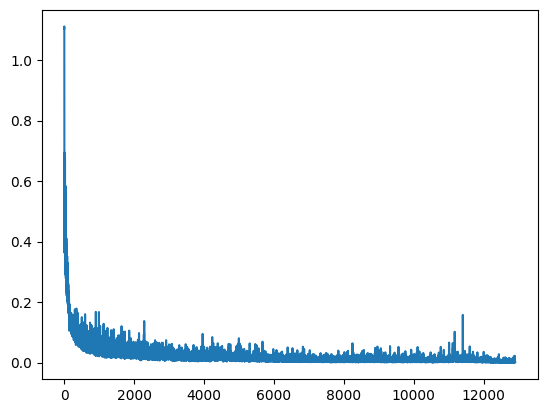

In [36]:
  plt.plot(results['Bengali3'][0])

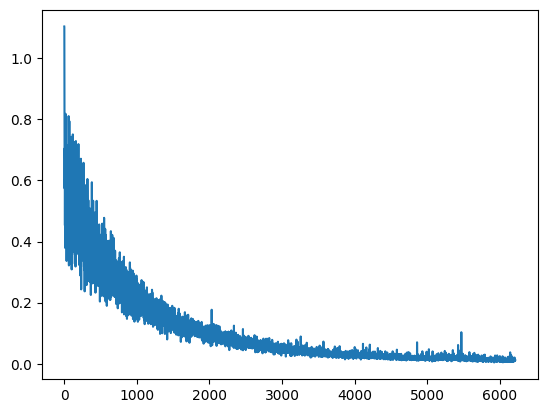

In [37]:
  plt.plot(results['Bengali2'][0])

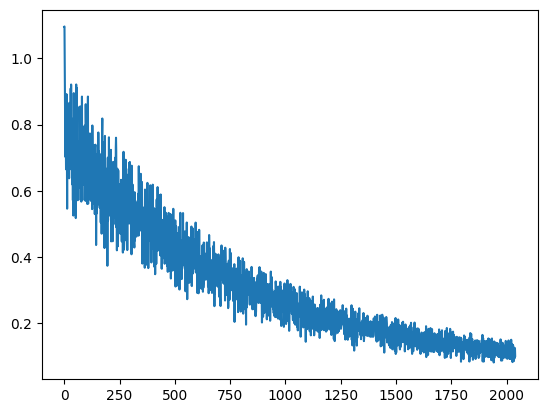

In [38]:
  plt.plot(results['Bengali'][0])

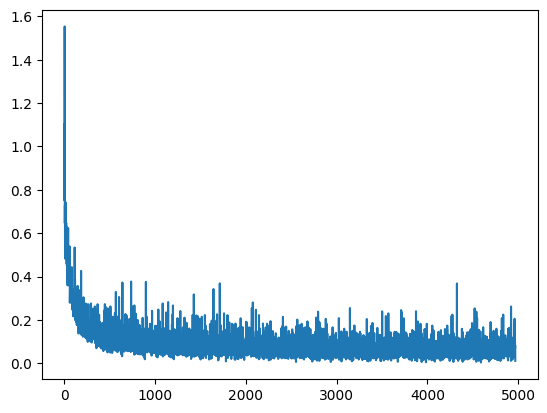

In [43]:
  plt.plot(results['Indonesian'][0])

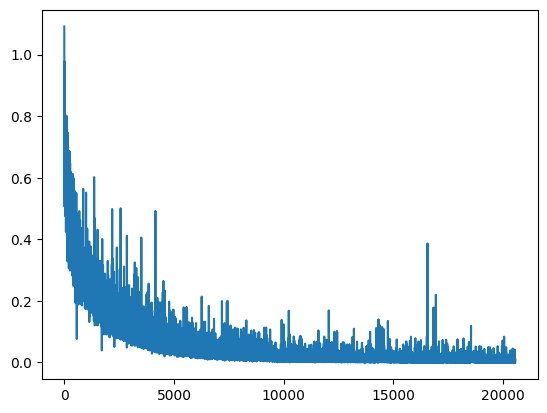

In [44]:
  plt.plot(results['Indonesian2'][0])

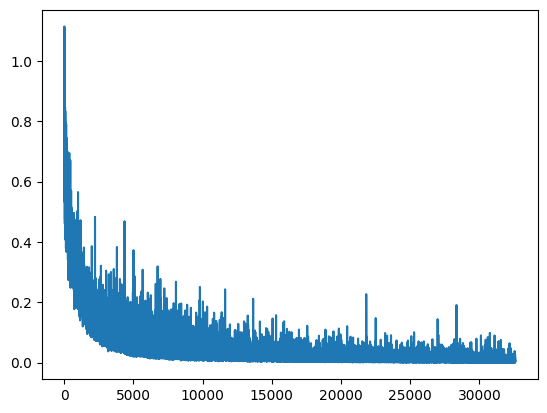

In [49]:
  plt.plot(results['Arabic'][0])